# TP: implementation de  quelques algorithmes populaires (SVM et AD)

Explorons une application sur le dataset [auto MGP](https://archive.ics.uci.edu/ml/datasets/Auto%2BMPG): contient des données sur des modèles de voitures

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# data = pd.read_csv('https://filedn.eu/lefeldrXcsSFgCcgc48eaLY/datasets/regression/auto-mpg.csv',index_col='car name')
# data.head()
df = pd.read_csv("auto-mpg.csv", index_col="car name")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [9]:
df["origin"].value_counts()

origin
1    249
3     79
2     70
Name: count, dtype: int64

- `mpg`: miles par galion
- `cylinder`: nombre de cylindres
- `displacement`: volume des pistons (en cc)
- `horsepower`: chevaux fiscaux
- `weight`: poids
- `acceleration`: acceleration (en s)

**Le but est de prédire la variable `mpg` en fonction des autres features**

## Préparation des données

### Nettoyer des données

- Explorer les variables avec les fonctions `describe` et `info`.
- Y a-t-il des valeurs manquantes dans les données ?
- Toutes les variables sont-elles du bon type ?
- Comment allez-vous traiter les anomalies dans la variable `horsepower` ?
- Quelles sont les variables fortement corrélées à la variable cible ?


Statistiques descriptives :
              mpg   cylinders  displacement       weight  acceleration  \
count  398.000000  398.000000    398.000000   398.000000    398.000000   
mean    23.514573    5.454774    193.425879  2970.424623     15.568090   
std      7.815984    1.701004    104.269838   846.841774      2.757689   
min      9.000000    3.000000     68.000000  1613.000000      8.000000   
25%     17.500000    4.000000    104.250000  2223.750000     13.825000   
50%     23.000000    4.000000    148.500000  2803.500000     15.500000   
75%     29.000000    8.000000    262.000000  3608.000000     17.175000   
max     46.600000    8.000000    455.000000  5140.000000     24.800000   

       model year      origin  
count  398.000000  398.000000  
mean    76.010050    1.572864  
std      3.697627    0.802055  
min     70.000000    1.000000  
25%     73.000000    1.000000  
50%     76.000000    1.000000  
75%     79.000000    2.000000  
max     82.000000    3.000000  

Informations sur

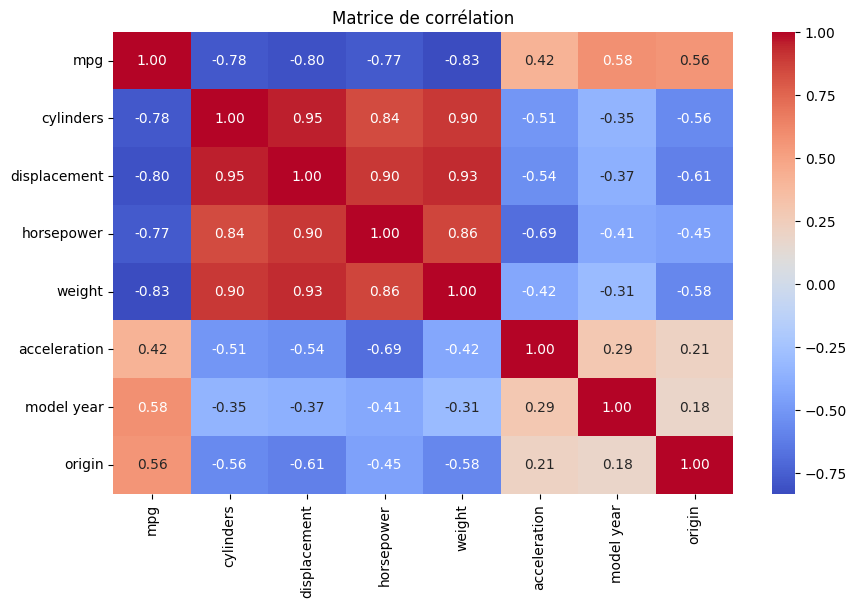


Variables fortement corrélées à 'mpg' :
mpg             1.000000
model year      0.579267
origin          0.563450
horsepower     -0.773453
cylinders      -0.775396
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration des données
print("Statistiques descriptives :")
print(df.describe())

print("\nInformations sur les données :")
print(df.info())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Détection des types de colonnes incorrects
print("\nTypes de colonnes :")
print(df.dtypes)

# Gestion des anomalies dans la colonne `horsepower`
# Identifier les valeurs non numériques ou anormales
print("\nValeurs uniques dans la colonne 'horsepower' :")
print(df["horsepower"].unique())

# Remplacer les valeurs non numériques par NaN et convertir en numérique
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

# Remplir les valeurs manquantes dans `horsepower` par la médiane
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

# Vérification des anomalies traitées
print("\nStatistiques de la colonne 'horsepower' après nettoyage :")
print(df["horsepower"].describe())

# Calcul des corrélations avec la variable cible (mpg)
correlation_matrix = df.corr()
target_corr = correlation_matrix["mpg"].sort_values(ascending=False)
print("\nCorrélations avec la variable cible (mpg) :")
print(target_corr)

# Visualisation des corrélations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

# Variables fortement corrélées à `mpg` (corrélation > 0.5 ou < -0.5)
strong_corr = target_corr[(target_corr > 0.5) | (target_corr < -0.5)]
print("\nVariables fortement corrélées à 'mpg' :")
print(strong_corr)

<Figure size 1600x800 with 0 Axes>

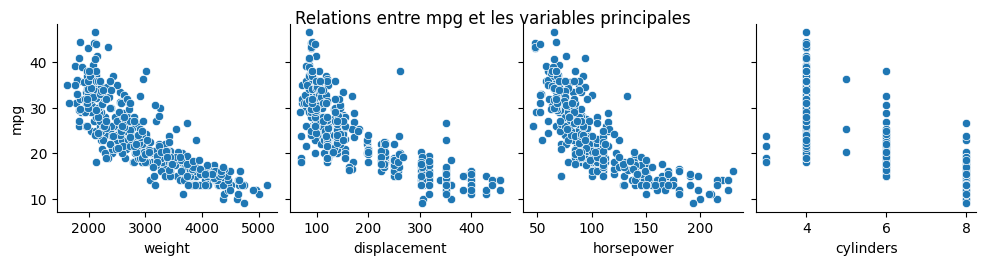

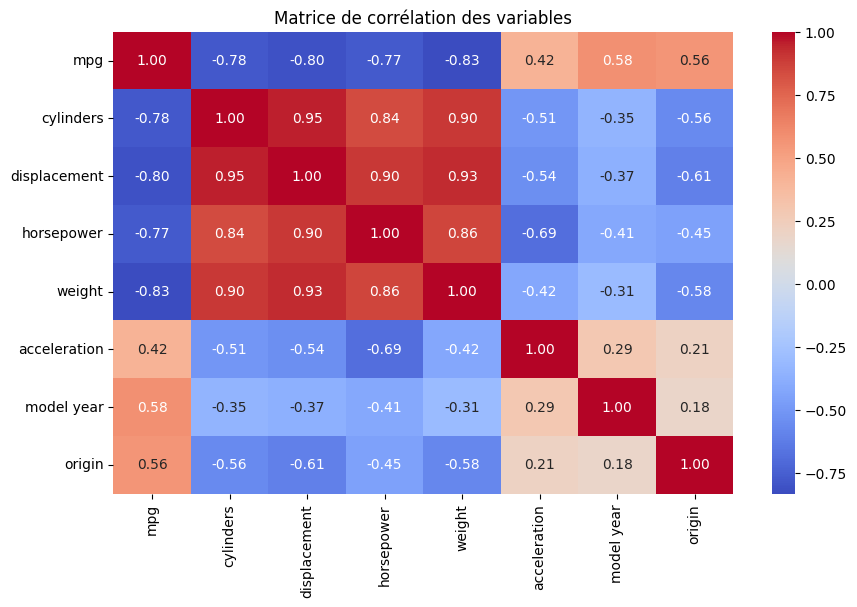

In [11]:
# Scatterplots pour visualiser les corrélations les plus fortes
plt.figure(figsize=(16, 8))
sns.pairplot(df, y_vars=["mpg"], x_vars=["weight", "displacement", "horsepower", "cylinders"])
plt.suptitle("Relations entre mpg et les variables principales", y=1.02)
plt.show()

# Heatmap pour examiner la multicolinéarité
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables")
plt.show()

### Préparer les données pour la modélisation

- Séparer la variable cible des variables explicatives.  
- Séparer les données d'entraînement des données de test.
- Créer une copie normalisée des données : `scaled_X_train` et `scaled_X_test`


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparer la variable cible des variables explicatives
X = df.drop(columns=["mpg"])  # Variables explicatives
y = df["mpg"]                # Variable cible

# Séparer les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Afficher les formes des ensembles de données
print("Taille des ensembles :")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print("Données normalisées prêtes.")

Taille des ensembles :
X_train : (318, 7), y_train : (318,)
X_test : (80, 7), y_test : (80,)
Données normalisées prêtes.


## Modélisation 

- Mettre en place des modèles SVM et AD adaptés à la tâche voulue.
- Entraîner les modèles sur les données d'entraînement.
- Utiliser les données normalisées dans le cas de modèles sensibles à l'échelle.
- Penser à utiliser la validation croisée

**SVM**

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Modèle SVM
svm_model = SVR(kernel="rbf")

# Validation croisée sur les données normalisées
svm_scores = cross_val_score(svm_model, scaled_X_train, y_train, cv=5, scoring="neg_mean_squared_error")

# Entraîner le modèle sur l'ensemble d'entraînement
svm_model.fit(scaled_X_train, y_train)

# Évaluer les performances moyennes et affichage
print("SVM - Validation croisée (MSE moyen) :", -svm_scores.mean())
print("SVM - Validation croisée (écart type) :", svm_scores.std())

SVM - Validation croisée (MSE moyen) : 11.19587450085409
SVM - Validation croisée (écart type) : 2.2308389090107466


**AD**

In [14]:
from sklearn.tree import DecisionTreeRegressor

# Modèle AD
ad_model = DecisionTreeRegressor(max_depth=10, random_state=42)

# Validation croisée sur les données non normalisées
ad_scores = cross_val_score(ad_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

# Entraîner le modèle sur l'ensemble d'entraînement
ad_model.fit(X_train, y_train)

# Évaluer les performances moyennes et affichage
print("AD - Validation croisée (MSE moyen) :", -ad_scores.mean())
print("AD - Validation croisée (écart type) :", ad_scores.std())

AD - Validation croisée (MSE moyen) : 15.252033669419887
AD - Validation croisée (écart type) : 3.461174965578445


## Evaluation des modèles

- Calculer les métriques adéquates.
- Tester le sur-apprentissage et le sous-apprentissage.
- Optimiser les paramètres des modèles

In [15]:
# 1. Évaluation des modèles

from sklearn.metrics import mean_squared_error, r2_score

# Prédictions SVM
svm_predictions = svm_model.predict(scaled_X_test)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)

print("SVM - Erreur quadratique moyenne (MSE) :", svm_mse)
print("SVM - Coefficient de détermination (R²) :", svm_r2)

# Prédictions AD
ad_predictions = ad_model.predict(X_test)
ad_mse = mean_squared_error(y_test, ad_predictions)
ad_r2 = r2_score(y_test, ad_predictions)

print("AD - Erreur quadratique moyenne (MSE) :", ad_mse)
print("AD - Coefficient de détermination (R²) :", ad_r2)

SVM - Erreur quadratique moyenne (MSE) : 6.803877654705611
SVM - Coefficient de détermination (R²) : 0.8734549436384174
AD - Erreur quadratique moyenne (MSE) : 11.549886054421767
AD - Coefficient de détermination (R²) : 0.7851841176603434


In [16]:
# 2. Test de sur-apprentissage ou sous-apprentissage

# Performances SVM sur l'ensemble d'entraînement
svm_train_predictions = svm_model.predict(scaled_X_train)
svm_train_mse = mean_squared_error(y_train, svm_train_predictions)

print("SVM - MSE sur l'entraînement :", svm_train_mse)

# Performances AD sur l'ensemble d'entraînement
ad_train_predictions = ad_model.predict(X_train)
ad_train_mse = mean_squared_error(y_train, ad_train_predictions)

print("AD - MSE sur l'entraînement :", ad_train_mse)

# Analyse :
# - Si MSE_train << MSE_test, le modèle est en sur-apprentissage.
# - Si MSE_train et MSE_test sont tous deux très élevés, le modèle est en sous-apprentissage.

SVM - MSE sur l'entraînement : 9.495737789702979
AD - MSE sur l'entraînement : 0.3015468703204552


In [17]:
# 3. Optimisation des paramètres des modèles
# SVM - Optimisation des hyperparamètres avec recherche sur grille :

from sklearn.model_selection import GridSearchCV

# Définir une grille de paramètres pour SVM
svm_param_grid = {
    "kernel": ["linear", "rbf", "poly"],
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"]
}

# Recherche sur grille avec validation croisée
svm_grid = GridSearchCV(SVR(), param_grid=svm_param_grid, cv=5, scoring="neg_mean_squared_error")
svm_grid.fit(scaled_X_train, y_train)

# Meilleurs paramètres et performance associée
print("SVM - Meilleurs paramètres :", svm_grid.best_params_)
print("SVM - Meilleur MSE (validation croisée) :", -svm_grid.best_score_)

SVM - Meilleurs paramètres : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Meilleur MSE (validation croisée) : 9.048182920680365


In [18]:
# 3. Optimisation des paramètres des modèles
# AD - Optimisation des hyperparamètres avec recherche sur grille :

# Définir une grille de paramètres pour AD
ad_param_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Recherche sur grille avec validation croisée
ad_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid=ad_param_grid, cv=5, scoring="neg_mean_squared_error")
ad_grid.fit(X_train, y_train)

# Meilleurs paramètres et performance associée
print("AD - Meilleurs paramètres :", ad_grid.best_params_)
print("AD - Meilleur MSE (validation croisée) :", -ad_grid.best_score_)

AD - Meilleurs paramètres : {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
AD - Meilleur MSE (validation croisée) : 12.419409884612097


**Quel modèle offre la meilleure performance sur ces données ?**

# Analyse des performances des modèles

## 1. Performances sur l'ensemble de test
### SVM :
- **MSE (test)** : 6.80 (plus faible que celui d'AD, indiquant une meilleure précision).
- **R² (test)** : 0.87 (meilleur que celui d'AD, proche de 1, ce qui montre une bonne explication de la variance).

### AD (Arbre de Décision) :
- **MSE (test)** : 11.55 (plus élevé, indiquant moins de précision).
- **R² (test)** : 0.78 (inférieur, montrant qu'il explique moins bien la variance).

**Conclusion** : SVM offre de meilleures performances sur les données de test.

---

## 2. Performances sur l'ensemble d'entraînement
### SVM :
- **MSE (entraînement)** : 9.50 (proche de celui sur le test, donc pas de sur-apprentissage apparent).

### AD :
- **MSE (entraînement)** : 0.30 (extrêmement faible, ce qui indique un **sur-apprentissage** important).

**Conclusion** : SVM est mieux généralisé, tandis qu'AD sur-apprend.

---

## 3. Validation croisée et optimisation des hyperparamètres
### SVM :
- **Meilleur MSE (validation croisée)** : 9.05 (valeur raisonnable, cohérente avec le test et l'entraînement).
- **Meilleurs hyperparamètres** : `{C: 10, gamma: 'auto', kernel: 'rbf'}`.

### AD :
- **Meilleur MSE (validation croisée)** : 12.42 (moins performant, confirmant que AD est moins adapté aux données).
- **Meilleurs hyperparamètres** : `{max_depth: 5, min_samples_leaf: 2, min_samples_split: 2}`.

**Conclusion** : SVM montre des résultats constants et fiables, tandis qu'AD est moins performant et souffre d'une forte variance.

---

## Conclusion Générale
Sur ces données, **SVM** offre la meilleure performance globale :
1. Un **MSE** plus faible sur l'ensemble de test.
2. Une meilleure généralisation (R² élevé, faible écart entre entraînement/test).
3. Des résultats stables après optimisation des hyperparamètres.

### Suggestions pour améliorer encore les performances :
1. Affiner davantage les hyperparamètres de SVM (par exemple, explorer d'autres valeurs pour `C` et `gamma`).
2. Tester des modèles complémentaires, tels que **Random Forest** ou **Gradient Boosting**.